# Retake Exam 2023 - Option strategy

# Guided Solution


Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving both problems. 

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

In [2]:
# numpy for working with matrices, etc. 
import numpy as np

# import pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick

# scipy for statistics and optimization 
from scipy import optimize
from scipy import stats

# typing 
from typing import Union

"""
functions from codelib
"""

# functions for calculating moments
import codelib.statistics.moments as mom
# functions for calculating risk metrics
import codelib.portfolio_optimization.risk_metrics as rm
# predefined plots
from codelib.visualization.base import fan_chart

In [3]:
from copy import deepcopy

# Problem 1: Option strategy

## Modelling the market

We assume that the market consists of three assets that follow a multivariate geometric Brownian motion 

$$
d\mathbf{V}_t = \mathbf{V}_t \odot \boldsymbol{\mu} dt + \mathbf{V}_t \odot \boldsymbol{\sigma} d\mathbf{Z}_t
$$

with 

$$
\boldsymbol{\mu} = \begin{pmatrix} 0.03 \\ 0.06 \\ 0.09 \end{pmatrix}
$$

and 

$$
\boldsymbol{\sigma}^2 = \boldsymbol{\sigma} \boldsymbol{\sigma}^\top = \mathbf{D} \mathbf{C} \mathbf{D}
$$

where the diffusion matrix is decomposed in respectively a diagonal matrix of volatilities  and a correlation matrix

$$
\mathbf{D} = \begin{pmatrix} 
0.06 & 0.0 & 0.0 \\
0.0 & 0.11 & 0.0 \\
0.0 & 0.0 & 0.16
\end{pmatrix}
$$

and 

$$
\mathbf{C} = \begin{pmatrix} 
1 & 0.2 & 0.2 \\
0.2 & 1 & 0.6 \\
0.2 & 0.6 & 1
\end{pmatrix}
$$



### Distribution of the value vector


$$
d \ln \mathbf{V}_t =     (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2))dt + \boldsymbol{\sigma} d\mathbf{Z}_t
$$

This implies that 

$$
\ln \mathbf{V}_T - \ln \mathbf{V}_0 =  (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T + \boldsymbol{\sigma} (\mathbf{Z}_T - \mathbf{Z}_0)
$$

Since we assume that the intial prices are equal to a vector of ones, we obtain

$$
\ln \mathbf{V}_T =  (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T + \boldsymbol{\sigma} (\mathbf{Z}_T - \mathbf{Z}_0) \sim N((\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T, \boldsymbol{\sigma}^2T)
$$

or equivalently the price vector must be log-normal

$$
\mathbf{V}_T \sim \log N ((\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T, \boldsymbol{\sigma}^2T)
$$

In [4]:
"""
Parameter assumptions
"""

# store values in vector and matrices
mu = np.array([0.03, 0.06, 0.09])
vols = np.array([0.06, 0.11, 0.16])
corr_mat = np.array([[1.0, 0.2, 0.2],
                     [0.2, 1.0, 0.6],
                     [0.2, 0.6, 1.0]])

# define covariance matrix
cov_mat = mom.corr_to_cov_matrix(corr_mat, vols)

# investment horizon 
horizon = 5.0

In [5]:
# the covariance matrix using codelib functions
cov_mat

array([[0.0036 , 0.00132, 0.00192],
       [0.00132, 0.0121 , 0.01056],
       [0.00192, 0.01056, 0.0256 ]])

In [6]:
# How to calculate the covariance matrix using the formula DCD
np.diag(vols) @ corr_mat @ np.diag(vols)

array([[0.0036 , 0.00132, 0.00192],
       [0.00132, 0.0121 , 0.01056],
       [0.00192, 0.01056, 0.0256 ]])

In [7]:
# the correlation matrix is the product of the cholesky decompostion
np.linalg.cholesky(corr_mat) @ np.linalg.cholesky(corr_mat).T

array([[1. , 0.2, 0.2],
       [0.2, 1. , 0.6],
       [0.2, 0.6, 1. ]])

In [8]:
"""
Define function to simulate risky assets
"""

def simulate_risky_assets(mu: np.ndarray,
                          cov_mat: np.ndarray,
                          horizon: float, 
                          dt: float=1.0/12,
                          num_sim: int=10000): 
    
    """
    Function simulating the risky assets. 
    """
    
    mu_scaled = (mu - 0.5 * np.diag(cov_mat)) * dt
    cov_mat_scaled = cov_mat * dt
    
    num_time_steps = int(horizon / dt)
    num_assets = len(mu)
    
    risky_log_ret = np.random.multivariate_normal(mu_scaled, cov_mat_scaled, size=(num_sim, num_time_steps))
    
    asset_prices = np.ones(((num_sim, num_time_steps + 1, num_assets)))
    asset_prices[:, 1:, :] = np.exp(np.cumsum(risky_log_ret, axis=1))
    
    return asset_prices

In [9]:
"""
Simulate risky assets, 100_000 different paths with weekly time-step
"""
dt = 1.0 / 52.0 
num_sim = 1_00_000
time_points = np.arange(0, horizon / dt + 1, 1) * dt
risky_asset_prices = simulate_risky_assets(mu=mu, cov_mat=cov_mat, horizon=horizon, dt=1.0/52, num_sim=num_sim)

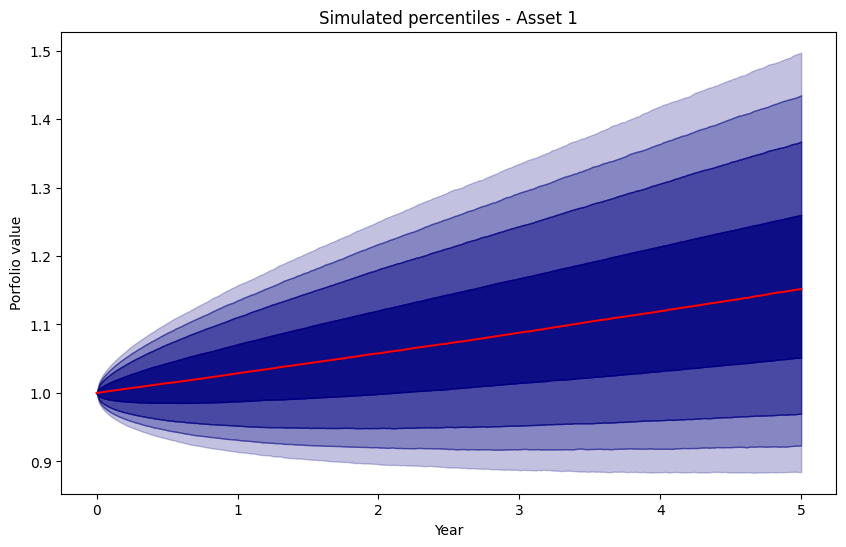

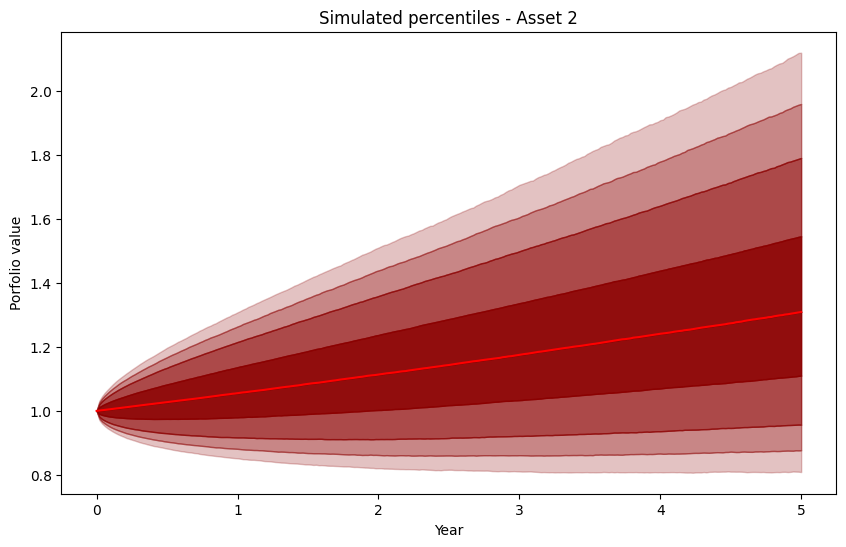

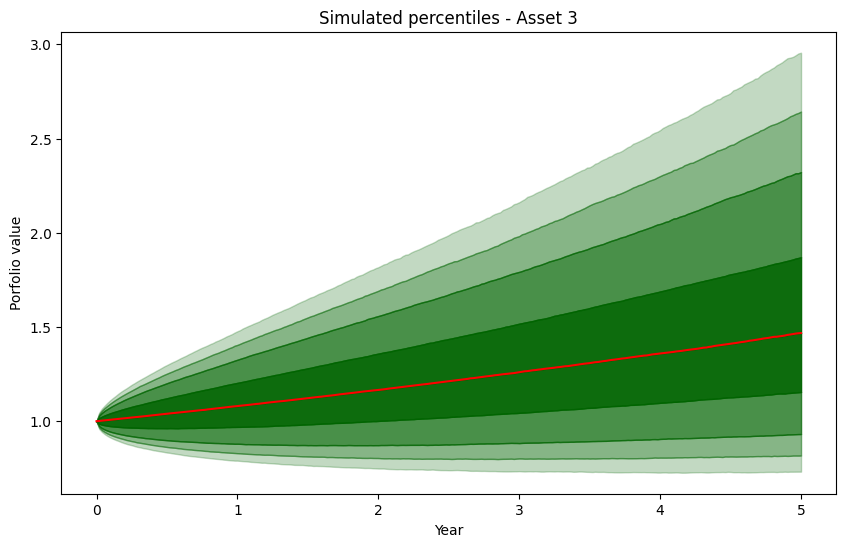

In [10]:
# calculate simulated percentiles
percentiles = np.percentile(risky_asset_prices, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

"""
Plot fan charts
"""

plot_colors = ['navy', 'darkred', 'darkgreen']

for i in range(3): 

    fig, ax = plt.subplots(figsize=(10, 6))

    fan_chart(time_points, percentiles[:, :, i], ax=ax, color=plot_colors[i])

    ax.set(ylabel="Porfolio value", xlabel="Year",
           title="Simulated percentiles - Asset {}".format(i + 1)); 

### Mean and covariance of $\mathbf{V}_T$

Since, we know that the price vector is log-normal, we can apply the known formulas for the expectation and covariance (see [here](https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf))

$$
\text{E}[e^{\ln \mathbf{V}_T}] = \text{E}[\mathbf{V}_T] = e^{T\boldsymbol{\mu} - \frac{1}{2}\text{diag}(T\boldsymbol{\sigma}^2) + \frac{1}{2}\text{diag}(T\boldsymbol{\sigma}^2)} = e^{T \boldsymbol{\mu}}
$$

and 

$$
\text{Cov}[e^{\ln \mathbf{V}_T}] =  \text{Cov}[\mathbf{V}_T] =  \text{E}[e^{\ln \mathbf{V}_T}] \text{E}[e^{\ln \mathbf{V}_T}]^\top \odot \left(e^{T\boldsymbol{\sigma}^2} - \mathbf{1} \right)
$$

### Mean and variance of a Buy-and-hold portfolio

$$
\text{E}[V_t^{BH}] = \mathbf{h}^\top \text{E}[\mathbf{V}_T]
$$

and 

$$
\text{Var}[V_t^{BH}] =  \mathbf{h}^\top \text{Cov}[\mathbf{V}_T] \mathbf{h}
$$

In [11]:
"""
Define functions
"""

def calculate_expectation_geo(mu: np.ndarray, horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the expectation of the value vector. 
    """
    
    return np.exp(horizon*mu)


def calculate_covariance_geo(mu: np.ndarray, sigma2: np.ndarray,  horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the variance-covariance matrix of the value vector. 
    """
    
    exp_v = calculate_expectation_geo(mu, horizon)
    
    return np.outer(exp_v, exp_v) * [np.exp(sigma2 * horizon) - 1]


### Comparing analytical and simulated values for equally weighted portfolio 

In [12]:
num_assets = len(mu)
eq_h = np.ones(num_assets) / num_assets

# simulated values for the portfolio 
portfolio_values = risky_asset_prices @ eq_h 

"""
Expected value 
"""

exp_port_analytical = np.array([rm.calculate_portfolio_mean(eq_h, calculate_expectation_geo(mu, t)) 
                                for t in time_points])

exp_port_sim = np.mean(portfolio_values, axis=0)

"""
Standard devation 
"""

std_port_analytical = np.array([rm.calculate_portfolio_std(eq_h, calculate_covariance_geo(mu, cov_mat, t)) 
                                for t in time_points])

std_port_sim = np.std(portfolio_values, axis=0)

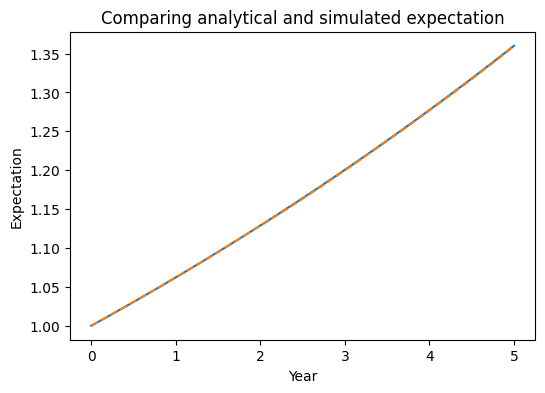

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, exp_port_analytical)

ax.plot(time_points, exp_port_sim, linestyle="--");

ax.set(ylabel="Expectation", xlabel="Year", title="Comparing analytical and simulated expectation"); 

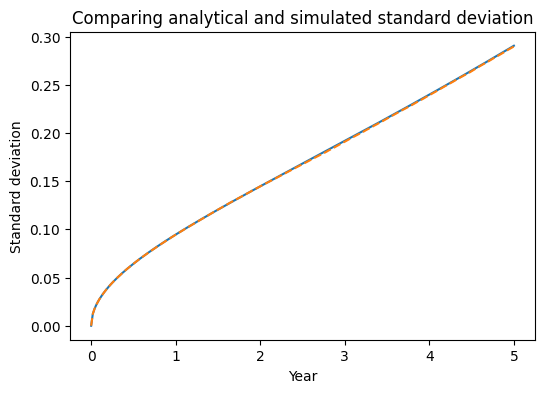

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, std_port_analytical)

ax.plot(time_points, std_port_sim, linestyle="--");

ax.set(ylabel="Standard deviation", xlabel="Year",
       title="Comparing analytical and simulated standard deviation"); 

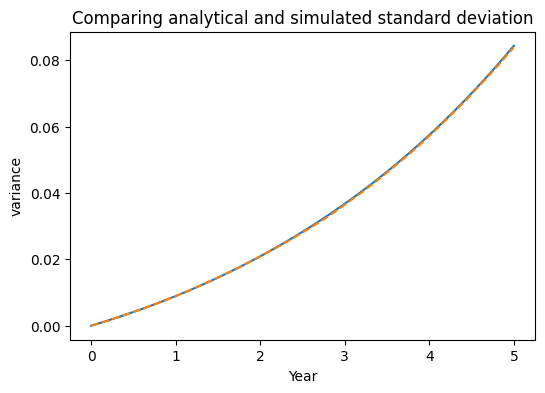

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, std_port_analytical**2)

ax.plot(time_points, std_port_sim**2, linestyle="--");

ax.set(ylabel="variance", xlabel="Year",
       title="Comparing analytical and simulated standard deviation"); 

In [16]:
# one year port. standard deviation
std_port_sim[52]

0.09443727522321578

In [17]:
# one year expectations of assets
calculate_expectation_geo(mu, 1.0)

array([1.03045453, 1.06183655, 1.09417428])

In [18]:
# one year covariance matrix of assets
calculate_covariance_geo(mu, cov_mat, 1.0)

array([[[0.0038295 , 0.00144526, 0.00216687],
        [0.00144526, 0.01372558, 0.01233398],
        [0.00216687, 0.01233398, 0.03104444]]])

### Compare asset characteristics - 1Y horizon

__Simulation based approach__

In order to calculate relevant metrics, we can use simulations. We simulate a panel of asset prices, calculate linear returns and calculate relevant metrics based on the simulated paths. 

In [19]:
horizon = 1.0
idx_hor = int(horizon / dt)

df_hor_asset_values = pd.DataFrame({'Asset 1': risky_asset_prices[:, idx_hor, 0] - 1.0,
                                    'Asset 2': risky_asset_prices[:, idx_hor, 1] - 1.0, 
                                    'Asset 3': risky_asset_prices[:, idx_hor, 2] - 1.0})


"""
Calculate some relevant metrics
"""

calc_cvar = lambda x: rm.calculate_conditional_value_at_risk(np.asarray(x), p=0.05)
calc_var = lambda x: np.percentile(x, q=5, axis=0)

df_res = df_hor_asset_values.aggregate([mom.calculate_mean,
                                        np.median,
                                        mom.calculate_std,
                                        mom.calculate_skewness,
                                        mom.calculate_kurtosis,
                                        calc_cvar,
                                        calc_var])

df_res.index = pd.Index(['Mean', 'Median' , 'Standard deviation', 'Skewness', 'Kurtosis', 'CVaR(5%)', 'VaR(5%)'])
df_res

,Asset 1,Asset 2,Asset 3
Mean,0.030397,0.061765,0.094418
Median,0.028611,0.055309,0.080442
Standard deviation,0.062016,0.116719,0.176217
Skewness,0.174677,0.332177,0.496206
Kurtosis,0.118056,0.180562,0.464680
CVaR(5%),-0.091877,-0.157110,-0.221229
VaR(5%),-0.068405,-0.118487,-0.169612


__Analytical results__

The asset prices follow a log normal distribution. Thus, the linear returns follow a shifted log-normal

$$
\mathbf{R}_t = \mathbf{V}_t - 1
$$

Clearly, if we are able to find the mean and variance of $\mathbf{V}_t$ (as we did above), we can easily find the mean and variance / standard devation of $\mathbf{R}_t$. Since the definitions of the [skewness](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) are respectively the third and fourth standardized moment, these quantities will be the same for $\mathbf{V}_t$ and $\mathbf{R}_t$. 

The analytical moments for a log-normal can be found [here](https://en.wikipedia.org/wiki/Log-normal_distribution)

To find the $\text{VaR}$ and $\text{CVaR}$, we can adapt the formulas from [here](https://en.wikipedia.org/wiki/Expected_shortfall)


Note: We can check the result by defining a shifted log-normal distribution using `scipy.stats.lognorm` - see below. 

In [20]:
def calculate_median_geo(mu: np.ndarray, sigma2: np.ndarray, horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the median of the value vector. 
    """
    
    return np.exp(horizon*mu - 0.5 * np.diag(sigma2))



def calculate_std_geo(mu: np.ndarray, sigma2: np.ndarray,  horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the individual std. of the value vector. 
    """
    
    exp_v = calculate_expectation_geo(mu, horizon)
    
    return np.sqrt(np.diag(np.outer(exp_v, exp_v) * (np.exp(sigma2 * horizon) - 1)))


def calculate_skewness_geo(sigma2: np.ndarray,  horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the skewness of the value vector. 
    """
    
    vols2 = np.diag(sigma2)
    
    return (np.exp(vols2) + 2)*np.sqrt(np.exp(vols2) - 1)


def calculate_kurtosis_geo(sigma2: np.ndarray,  horizon=1.0, excess=True) -> np.ndarray:
    
    """
    Function calculating the kurtosis matrix of the value vector. 
    """
    
    vols2 = np.diag(sigma2)
    kurt = 1*np.exp(4*vols2) + 2*np.exp(3*vols2) + 3 * np.exp(2*vols2) - 3
    
    if excess: 
        return kurt - 3
    else: 
        return kurt

    
def calculate_value_at_risk_geo(mu: np.ndarray, sigma2: np.ndarray,  horizon=1.0, p=0.05) -> np.ndarray:
    
    """
    Function calculating the individual value at risk of the value vector. 
    """
    
    vols2 = np.diag(cov_mat)
    m = mu - 0.5*vols2
    z = stats.norm().ppf(p)
    return np.exp(z * np.sqrt(vols2)) * np.exp(m)


def calculate_cond_value_at_risk_geo(mu: np.ndarray, sigma2: np.ndarray,  horizon=1.0, p=0.05) -> np.ndarray:
    
    """
    Function calculating the individual cond. value at risk of the value vector. 
    """
    
    vols2 = np.diag(cov_mat)
    m = mu - 0.5*vols2
    z = stats.norm().ppf(p)
    
    
    return -(1 - stats.norm.cdf(z - np.sqrt(vols2)) / p * np.exp(m))

In [21]:
"""
Analytical results 
"""

df_res_analytical = deepcopy(df_res)

df_res_analytical.loc['Mean', :] = calculate_expectation_geo(mu, horizon) - 1.0
df_res_analytical.loc['Median', :] = calculate_median_geo(mu, cov_mat, horizon) - 1.0
df_res_analytical.loc['Standard deviation', :] = calculate_std_geo(mu, cov_mat, horizon)
df_res_analytical.loc['Skewness', :] = calculate_skewness_geo(cov_mat, horizon)
df_res_analytical.loc['Kurtosis', :] = calculate_kurtosis_geo(cov_mat, horizon)
df_res_analytical.loc['CVaR(5%)', :] = calculate_cond_value_at_risk_geo(mu, cov_mat, horizon, p=0.05)
df_res_analytical.loc['VaR(5%)', :] = calculate_value_at_risk_geo(mu, cov_mat, horizon, p=0.05) - 1.0

In [22]:
# simulation based
df_res

,Asset 1,Asset 2,Asset 3
Mean,0.030397,0.061765,0.094418
Median,0.028611,0.055309,0.080442
Standard deviation,0.062016,0.116719,0.176217
Skewness,0.174677,0.332177,0.496206
Kurtosis,0.118056,0.180562,0.464680
CVaR(5%),-0.091877,-0.157110,-0.221229
VaR(5%),-0.068405,-0.118487,-0.169612


In [23]:
# analytical
df_res_analytical

,Asset 1,Asset 2,Asset 3
Mean,0.030455,0.061837,0.094174
Median,0.028601,0.055432,0.080258
Standard deviation,0.061883,0.117156,0.176194
Skewness,0.180379,0.332344,0.487264
Kurtosis,0.057899,0.197010,0.425079
CVaR(5%),-0.092550,-0.163208,-0.231963
VaR(5%),-0.068064,-0.119252,-0.169707


In [24]:
"""
Check with scipy.stats.lognorm
"""

lognorm1 = stats.lognorm(s=np.sqrt(cov_mat[0, 0]),
                         scale=np.exp(mu[0] - 0.5 * cov_mat[0, 0]),
                         loc=-1)

'\nCheck with scipy.stats.lognorm\n'

In [26]:
lognorm1.stats('mvsk')

(0.030454533953516938,
 0.003829500532662512,
 0.1803787057291006,
 0.05789918746136724)

In [27]:
lognorm1.ppf(0.05)

-0.06806407589200525

## Portfolio optimization 

### Minimum CVaR(5%) portfolio

The investors objective reads 

$$
\mathbf{h}^* = \arg \min \text{CVaR}(5\%)
$$ 

subject to

$$
\mathbf{h}^\top \mathbf{1} = 1
$$

and a no-shorting constraint

$$
\mathbf{h} \geq 0
$$

In [28]:
# define asset prices at horizon
asset_prices_at_horizon = risky_asset_prices[:, idx_hor, :]

In [29]:
def calculate_min_cvar_portfolio(asset_prices, h_init=None):
    
    if h_init is None: 
        h_init = np.ones(asset_prices.shape[1]) / asset_prices.shape[1]
    
    obj = lambda h: -rm.calculate_conditional_value_at_risk(asset_prices @ h, p=0.05)
    
    budget_constraint = {'type': 'eq', 'fun': lambda h: h.sum() - 1.0}
    res = optimize.minimize(obj,
                   x0=h_init,
                   method='SLSQP',
                   constraints=[budget_constraint], #budget_constraint, 
                   options={'disp': True,
                            'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1.5e-7},
                   bounds=[(0.0, 1.0)] * len(h_init))
    
    return res['x']

In [30]:
h_min_cvar = calculate_min_cvar_portfolio(asset_prices_at_horizon, eq_h)
h_min_cvar

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9211428024174854
            Iterations: 22
            Function evaluations: 103
            Gradient evaluations: 22


array([0.75520039, 0.20250692, 0.04229269])

### Optimal portfolios

In [31]:
def calculate_target_portfolio(asset_prices, target, h_init=None):
    
    if h_init is None: 
        h_init = np.ones(asset_prices.shape[1]) / asset_prices.shape[1]
    
    obj = lambda h: -np.mean(asset_prices @ h)
    
    budget_constraint = {'type': 'eq', 'fun': lambda h: h.sum() - 1.0}
    cvar_constraint = {'type': 'ineq', 'fun': lambda h: rm.calculate_conditional_value_at_risk(asset_prices @ h, p=0.05) - target}
    
    res = optimize.minimize(obj,
                   x0=h_init,
                   method='SLSQP',
                   constraints=[budget_constraint, cvar_constraint], #budget_constraint, 
                   options={'disp': True,
                            'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1.5e-7},
                   bounds=[(0.0, 1.0)] * len(h_init))
    
    return res['x']

In [32]:
cvar_targets = np.linspace(0.085, 0.23, 20)

h_cvar_opt_all = np.array([calculate_target_portfolio(asset_prices_at_horizon, 1 - ct, eq_h)
                           for ct in cvar_targets])

# calculate_target_portfolio(asset_prices_at_horizon, 0.85, eq_h)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0479943706382806
            Iterations: 433
            Function evaluations: 4701
            Gradient evaluations: 432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.052700543522341
            Iterations: 103
            Function evaluations: 1135
            Gradient evaluations: 103
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0564253724909978
            Iterations: 126
            Function evaluations: 1445
            Gradient evaluations: 126
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0596792689461758
            Iterations: 21
            Function evaluations: 80
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0626564184364473
            Iterations: 26
        

In [33]:
calc_port_mean = lambda h: np.mean(asset_prices_at_horizon @ h) - 1.0
calc_port_cvar = lambda h: 1 - rm.calculate_conditional_value_at_risk(asset_prices_at_horizon @ h, p=0.05)

In [34]:
port_cvar = np.apply_along_axis(calc_port_cvar, 1, h_cvar_opt_all)
port_mean = np.apply_along_axis(calc_port_mean, 1, h_cvar_opt_all)

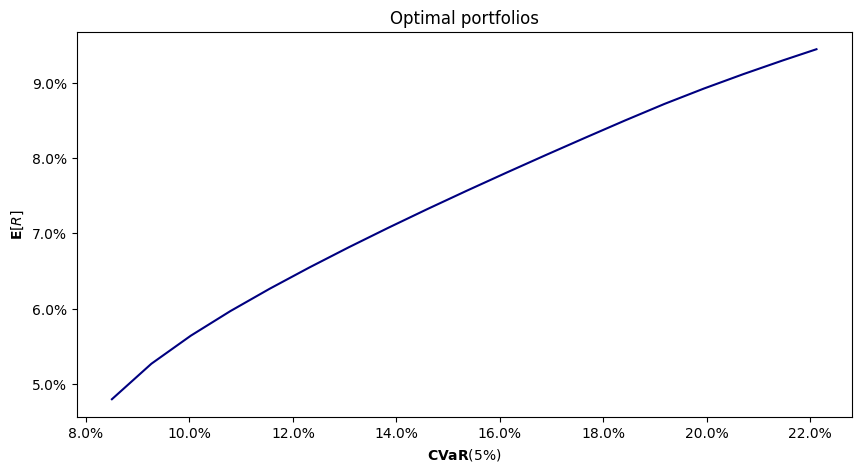

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(port_cvar, port_mean, color="navy")
ax.set(xlabel="$\\mathbf{CVaR}(5\%)$", ylabel="$\\mathbf{E}[R]$", title="Optimal portfolios"); 

xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)

(0.0, 1.0)

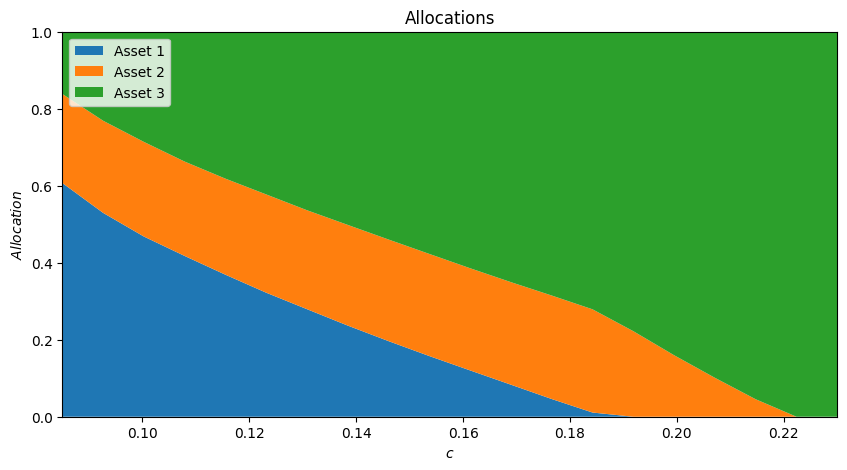

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(cvar_targets, h_cvar_opt_all.T, labels=['Asset 1', 'Asset 2', 'Asset 3']); 
ax.set_xlabel('$c$')
ax.set_ylabel('$Allocation$')
ax.set_title('Allocations')
ax.legend(loc='upper left');
ax.set_xlim([cvar_targets[0], cvar_targets[-1]])
ax.set_ylim([0, 1])

## Introducing options 

### Option prices

The Black-Scholes-Merton option pricing formula is given by (a generic asset, implied vol and risk free rate will change depending on asset, strike and time to expiry)

\begin{align}
  C(V_t, t) &=  e^{-r \tau}E^\mathbb{Q}[\max (V_T - K, 0)]\\
  &= N(d_+)V_t - N(d_-)Ke^{-r\tau} \\
  d_+ &= \frac{1}{\sigma_{IV}\sqrt{\tau}}\left[\ln\left(\frac{V_{t}}{K}\right) + \left(r + \frac{\sigma_{IV}^2}{2}\right)\tau\right] \\
  d_- &= d_+ - \sigma\sqrt{\tau}
\end{align}


In [37]:
# time to maturity / expiry of option 
ttm = 1.0
# risk free rate
r = 0.02
# strikes
strike1 = 1.0
strike2 = 1.1
# implied vols
imp_vol1 = 0.18
imp_vol2 = 0.16

In [38]:
def bsm_call_price(asset_prices: Union[np.ndarray, float],
                   rates: Union[np.ndarray, float],
                   implied_vols: Union[np.ndarray, float],
                   strike: float,
                   ttm: float) -> np.ndarray:

    """
    Calculates the Black-Scholes-Merton call option pricing for a given set of parameters.

    Parameters
    ------------
    asset_prices:
        The current price(s) of the underlying asset(s).

    rates:
        The risk-free interest rate(s).

    implied_vols:
        The implied volatility(ies) of the underlying assets.
        
    strike:
        The strike price of the option.

    ttm:
        Time to maturity of the option in years.

    Returns
    -----------
    np.ndarray:
        An array containing the calculated call option prices.

    """

    d = 1 / (implied_vols * np.sqrt(ttm)) * (np.log(asset_prices / strike) + (rates + implied_vols**2 / 2) * ttm)
    d_ = d - implied_vols * np.sqrt(ttm)

    prices = stats.norm.cdf(d) * asset_prices - stats.norm.cdf(d_) * strike * np.exp(-rates * ttm)

    return prices

In [39]:
call_price1 = bsm_call_price(asset_prices=1.0, rates=r, implied_vols=imp_vol1, strike=strike1, ttm=ttm)
call_price1

0.08134008370826207

In [40]:
call_price2 = bsm_call_price(asset_prices=1.0, rates=r, implied_vols=imp_vol2, strike=strike2, ttm=ttm)
call_price2

0.0343345149079638

### Check pricing using risk neutral pricing using simulations

Under risk neutral pricing, the assets earn the risk free rate. Thus, we have to calculate the expectation under this assumption:

$$
dV_{3,t} = r V_{3, t}dt + \sigma_{3} V_{3, t}dZ_t^\mathbb{Q}
$$

and therefore

$$
d \log V_{3,t} = (r - \sigma_3^2 / 2) dt + \sigma_3 dZ_t^\mathbb{Q}
$$

In [41]:
# simulate risk neutral prices
rn_asset_prices1 = np.exp(np.random.normal(loc=(r - 0.5 * imp_vol1**2)*ttm, scale=np.sqrt(ttm) * imp_vol1, size=num_sim))
rn_asset_prices2 = np.exp(np.random.normal(loc=(r - 0.5 * imp_vol2**2)*ttm, scale=np.sqrt(ttm) * imp_vol2, size=num_sim))

In [42]:
# calculate pay-off under risk neutral measure
rn_avg_pay_off1 = np.average(np.clip(rn_asset_prices1 - strike1, 0.0, np.inf))
rn_avg_pay_off2 = np.average(np.clip(rn_asset_prices2 - strike2, 0.0, np.inf))

In [43]:
# discount with risk free rate back to time zero
discount_rn_avg_pay_off1 = np.exp(-r * ttm) * rn_avg_pay_off1
discount_rn_avg_pay_off2 = np.exp(-r * ttm) * rn_avg_pay_off2

In [44]:
discount_rn_avg_pay_off1

0.08175580359008909

In [45]:
# option 1
call_price1

0.08134008370826207

In [46]:
discount_rn_avg_pay_off2

0.03414431508825724

In [47]:
# option 2
call_price2

0.0343345149079638

### Pay-off profile

In [48]:
# calculate pay-off under the real world measure
pay_off1 = np.clip(asset_prices_at_horizon[:, 2] - strike1, 0.0, np.inf)
pay_off2 = np.clip(asset_prices_at_horizon[:, 2] - strike2, 0.0, np.inf)

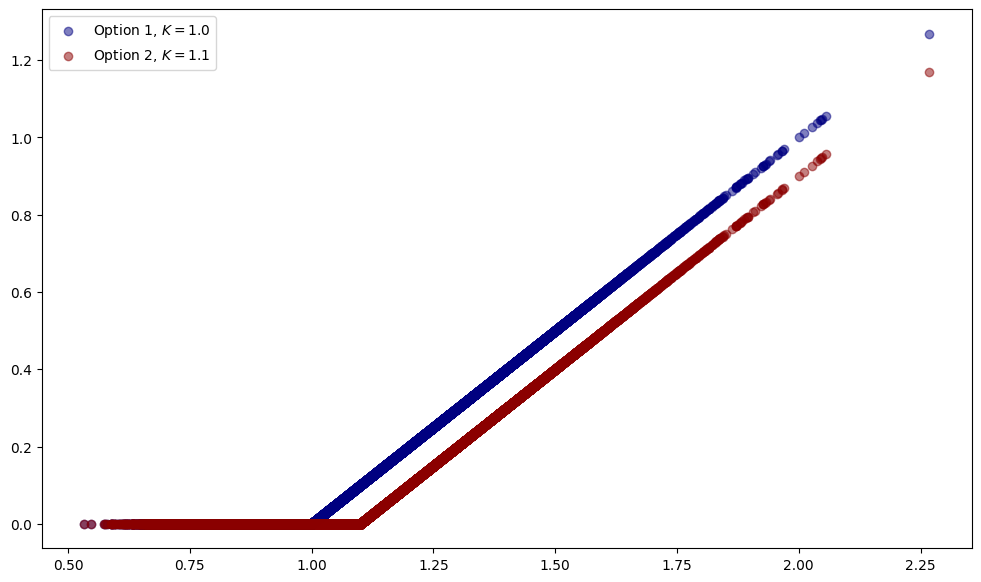

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(asset_prices_at_horizon[:, 2], pay_off1, color="navy", label="Option 1, $K=1.0$", alpha=0.5)
ax.scatter(asset_prices_at_horizon[:, 2], pay_off2, color="darkred", label="Option 2, $K=1.1$", alpha=0.5)

ax.legend();

### Expected return  call option

#### Simulation based

In [50]:
# calculate avg. pay-off under the real world measure
avg_pay_off1 = np.average(np.clip(asset_prices_at_horizon[:, 2] - strike1, 0.0, np.inf))
avg_pay_off2 = np.average(np.clip(asset_prices_at_horizon[:, 2] - strike2, 0.0, np.inf))

# calculate median pay-off
median_pay_off1 = np.median(np.clip(asset_prices_at_horizon[:, 2] - strike1, 0.0, np.inf))
median_pay_off2 = np.median(np.clip(asset_prices_at_horizon[:, 2] - strike2, 0.0, np.inf))

In [51]:
# calculate average return 
avg_ret1 = avg_pay_off1 / call_price1 - 1.0
avg_ret2 = avg_pay_off2 / call_price2 - 1.0

# calculate median return
median_ret1 = median_pay_off1 / call_price1 - 1.0
median_ret2 = median_pay_off2 / call_price2 - 1.0

In [52]:
df_call_ret = pd.DataFrame({'Average': [avg_ret1, avg_ret2],
                            'Median': [median_ret1, median_ret2]},
                            index=pd.Index(['Option 1', 'Option 2']))

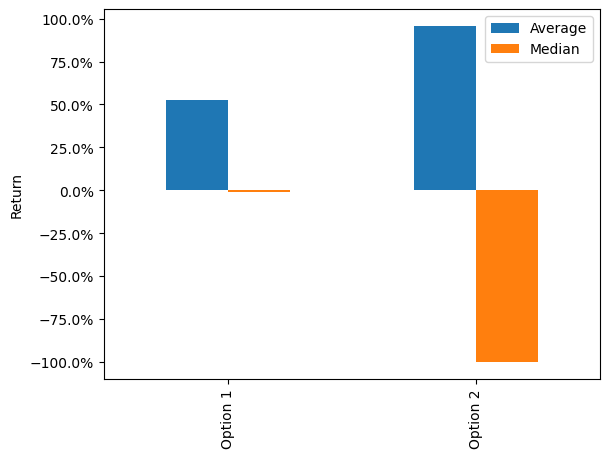

In [53]:
ax = df_call_ret.plot(kind='bar')
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.yaxis.set_major_formatter(xticks)
ax.set(ylabel="Return");

__An analytical formula for the expected return__

The actual expected pay off is based on the real world probability measure. This expectation is given by 

\begin{align}
   \mathbb{E}^\mathbb{P}[\max (V_T - K, 0)] &= N(d_+)e^{\mu \tau} - N(d_-)K \\
  d_+ &= \frac{1}{\sigma\sqrt{\tau}}\left[\ln\left(\frac{V_{t}}{K}\right) + \left(\mu + \frac{\sigma^2}{2}\right)\tau\right] \\
  d_- &= d_+ - \sigma\sqrt{\tau}
\end{align}

In [54]:
def bsm_call_expected_pay_off(asset_prices: Union[np.ndarray, float],
                              mu: Union[np.ndarray, float],
                              vols: Union[np.ndarray, float],
                              strike: float,
                              ttm: float) -> np.ndarray:

    """
    Calculates the expected call pay-off under the assumption of a geometric brownian motion.

    Parameters
    ------------
    asset_prices:
        The current price(s) of the underlying asset(s).

    mu:
        drift in geometric brownian motion.

    vols:
        The volatility(ies) of the underlying assets.
        
    strike:
        The strike price of the option.

    ttm:
        Time to maturity of the option in years.

    Returns
    -----------
    np.ndarray:
        An array containing the calculated call option prices.

    """

    d = 1 / (vols * np.sqrt(ttm)) * (np.log(asset_prices / strike) + (mu + vols**2 / 2) * ttm)
    d_ = d - vols * np.sqrt(ttm)

    pay_off =  np.exp(mu * ttm) * stats.norm.cdf(d) * asset_prices - stats.norm.cdf(d_) * strike

    return pay_off

In [55]:
ana_exp_pay_off1 = bsm_call_expected_pay_off(asset_prices=1.0, 
                          mu=mu[2],
                          vols=np.sqrt(cov_mat[2, 2]),
                          strike=strike1, 
                          ttm=ttm)

ana_exp_pay_off2 = bsm_call_expected_pay_off(asset_prices=1.0, 
                          mu=mu[2],
                          vols=np.sqrt(cov_mat[2, 2]),
                          strike=strike2, 
                          ttm=ttm)

ana_exp_ret1 = ana_exp_pay_off1 / call_price1 - 1.0
ana_exp_ret2 = ana_exp_pay_off2 / call_price2 - 1.0

In [56]:
ana_exp_pay_off1

0.12411424298853624

In [57]:
np.average(np.clip(risky_asset_prices[:, idx_hor, 2] - strike1, 0.0, np.inf))

0.1242272320274326

### Plot expected return as a function of the implied volatility

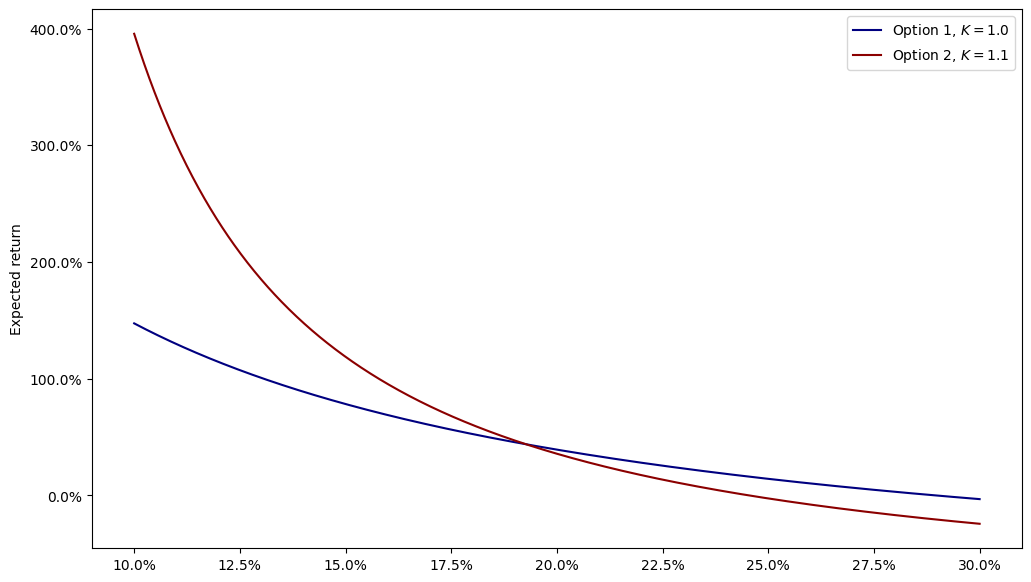

In [58]:
all_ivs = np.linspace(0.1, 0.30, 1000)
all_expected_returns1 = np.array([ana_exp_pay_off1 / bsm_call_price(asset_prices=1.0, rates=r, implied_vols=iv, strike=strike1, ttm=ttm) - 1.0 for iv in all_ivs])
all_expected_returns2 = np.array([ana_exp_pay_off2 / bsm_call_price(asset_prices=1.0, rates=r, implied_vols=iv, strike=strike2, ttm=ttm) - 1.0 for iv in all_ivs])

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(all_ivs, all_expected_returns1, color="navy", label="Option 1, $K=1.0$")
ax.plot(all_ivs, all_expected_returns2, color="darkred", label="Option 2, $K=1.1$")
ax.set(ylabel="Expected return")

xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)

ax.legend();

### Plot expected return as a function of $\mu_3$

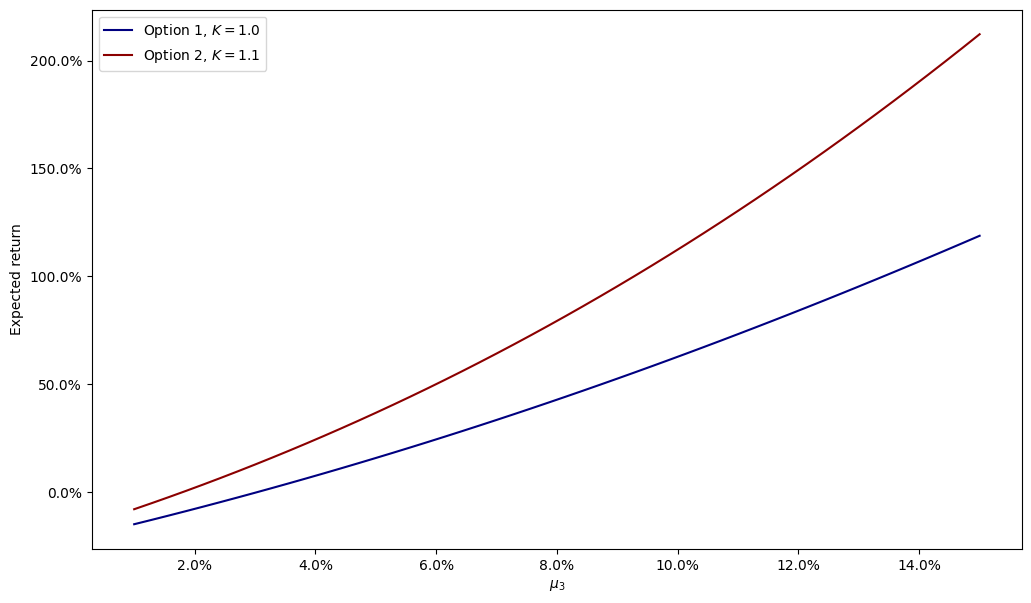

In [59]:
all_mus = np.linspace(0.01, 0.15, 50)
all_expected_returns1 = np.array([bsm_call_expected_pay_off(asset_prices=1.0, mu=m,
                                                            vols=np.sqrt(cov_mat[2, 2]),
                                                            strike=strike1, ttm=ttm) / call_price1 - 1.0 for m in all_mus])
all_expected_returns2 = np.array([bsm_call_expected_pay_off(asset_prices=1.0, mu=m,
                                                            vols=np.sqrt(cov_mat[2, 2]),
                                                            strike=strike2, ttm=ttm) / call_price2 - 1.0 for m in all_mus])

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(all_mus, all_expected_returns1, color="navy", label="Option 1, $K=1.0$")
ax.plot(all_mus, all_expected_returns2, color="darkred", label="Option 2, $K=1.1$")
ax.set(xlabel="$\mu_3$")
ax.set(ylabel="Expected return")

xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)

ax.legend();

### Plot expected return as a function of $\sigma_3$

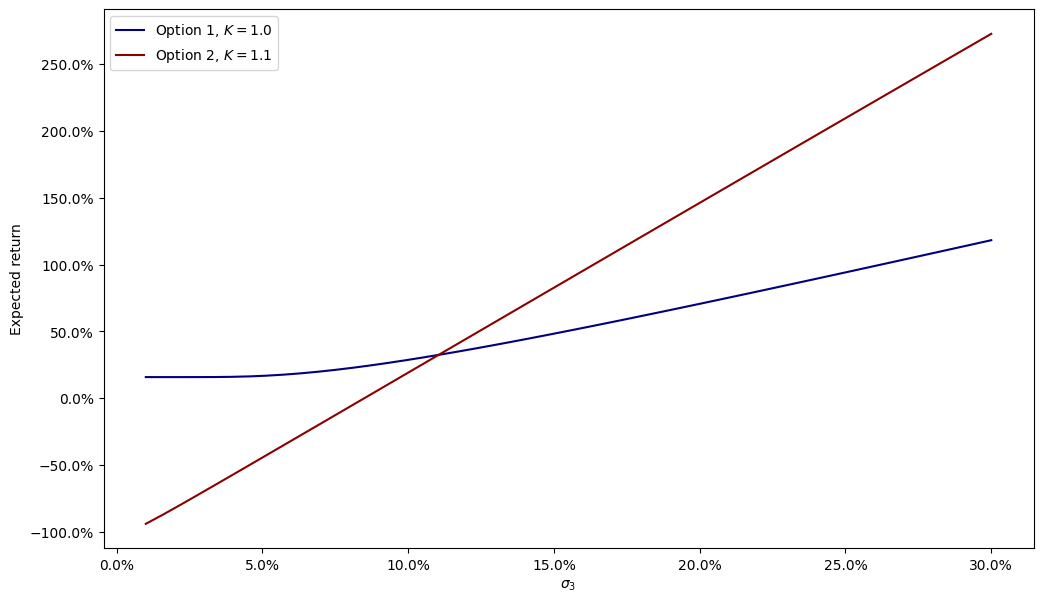

In [60]:
all_sigmas = np.linspace(0.01, 0.3, 50)
all_expected_returns1 = np.array([bsm_call_expected_pay_off(asset_prices=1.0, mu=mu[2],
                                                            vols=s,
                                                            strike=strike1, ttm=ttm) / call_price1 - 1.0 for s in all_sigmas])
all_expected_returns2 = np.array([bsm_call_expected_pay_off(asset_prices=1.0, mu=mu[2],
                                                            vols=s,
                                                            strike=strike2, ttm=ttm) / call_price2 - 1.0 for s in all_sigmas])

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(all_sigmas, all_expected_returns1, color="navy", label="Option 1, $K=1.0$")
ax.plot(all_sigmas, all_expected_returns2, color="darkred", label="Option 2, $K=1.1$")
ax.set(xlabel="$\sigma_3$")
ax.set(ylabel="Expected return")

xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)

ax.legend();

### Plot delta profile

The delta of a call option is given by 

$$
\Delta_{call} = N(d_{+})
$$

In [63]:
def bsm_call_delta(asset_prices: Union[np.ndarray, float],
                   rates: Union[np.ndarray, float],
                   implied_vols: Union[np.ndarray, float],
                   strike: float,
                   ttm: float):
    """
    Calculates the delta of a call option using the Black-Scholes-Merton model.

    Parameters
    ------------
    asset_prices:
        The current price(s) of the underlying asset(s).

    rates:
        The risk-free interest rate(s).

    implied_vols:
        The implied volatility(ies) of the underlying asset(s).
        
    strike:
        The strike price of the call option.

    ttm:
        Time to maturity of the option in years.

    Returns
    ------------
    float:
        The calculated call option delta.
    """

    d = 1 / (implied_vols * np.sqrt(ttm)) * (np.log(asset_prices / strike) + (rates + implied_vols ** 2 / 2) * ttm)

    return stats.norm.cdf(d)

In [64]:
prices = np.linspace(0.5, 2.0, 1000)

deltas1 =  bsm_call_delta(prices, r, imp_vol1, strike1, ttm)
deltas2 =  bsm_call_delta(prices, r, imp_vol2, strike2, ttm)

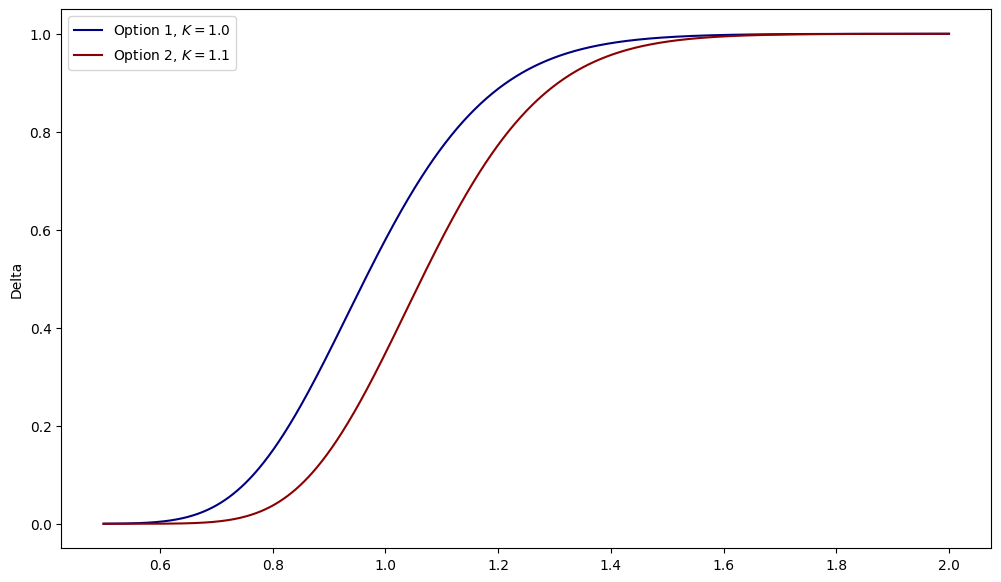

In [65]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(prices, deltas1, color="navy", label="Option 1, $K=1.0$")
ax.plot(prices, deltas2, color="darkred", label="Option 2, $K=1.1$")
ax.set(ylabel="Delta")
ax.legend();

## Equity replacement

The number of options is found using the formula

$$
h_{call} = \frac{0.1}{\Delta_{call}}
$$

In [66]:
# find option delta
delta1 =  bsm_call_delta(1.0, r, imp_vol1, strike1, ttm)
delta2 =  bsm_call_delta(1.0, r, imp_vol2, strike2, ttm)

In [67]:
# holding option 1
num_call1 = 0.1 / delta1
num_call1

0.1725047587415286

In [68]:
# holding option 2
num_call2 = 0.1 / delta2
num_call2

0.2873450060644981

In [69]:
# find benchmark portfolio
h_cvar_opt = calculate_target_portfolio(asset_prices_at_horizon, 1 - 0.16, eq_h)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1.0776461835713362
            Iterations: 73
            Function evaluations: 701
            Gradient evaluations: 69


In [87]:
pd.DataFrame({'Holdings': h_cvar_opt}, index=['Asset 1', 'Asset 2', 'Asset 3'])

,Holdings
Asset 1,0.126624
Asset 2,0.265378
Asset 3,0.607998


In [71]:
# define alternative portfolios
h_cvar_opt_ = np.r_[h_cvar_opt, 0.0, 0.0]
h_cvar_opt_call1 = np.r_[h_cvar_opt[0] + 0.1 - num_call1 * call_price1, h_cvar_opt[1], h_cvar_opt[2] - 0.1, num_call1, 0.0]
h_cvar_opt_call2 = np.r_[h_cvar_opt[0] + 0.1 - num_call2 * call_price2, h_cvar_opt[1], h_cvar_opt[2] - 0.1, 0.0, num_call2]

In [72]:
# check budget constraint
initial_prices = np.array([1.0, 1.0, 1.0, call_price1, call_price2])
h_cvar_opt_call1 @ initial_prices

1.0

In [73]:
# check budget constraint
h_cvar_opt_call2 @ initial_prices

1.0

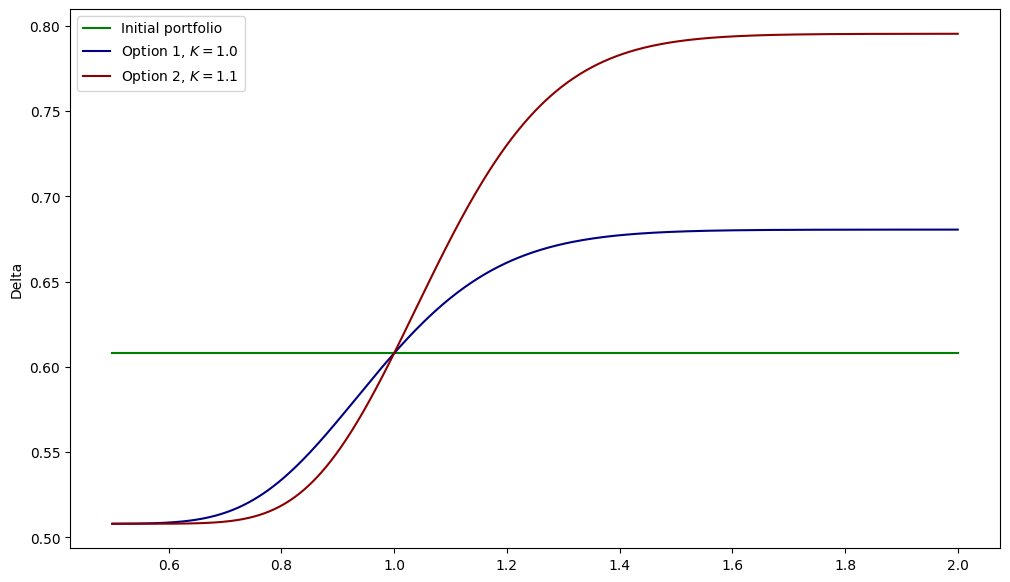

In [74]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(prices, h_cvar_opt[2] * np.ones_like(prices), color="green", label="Initial portfolio")
ax.plot(prices, h_cvar_opt[2] - 0.1 + num_call1 * deltas1, color="navy", label="Option 1, $K=1.0$")
ax.plot(prices, h_cvar_opt[2] - 0.1 + num_call2 * deltas2, color="darkred", label="Option 2, $K=1.1$")
ax.set(ylabel="Delta")
ax.legend();

In [75]:
# asset prices with call pay off
asset_prices_w_call_payoff = np.c_[asset_prices_at_horizon, pay_off1, pay_off2]

# define pay off
init_port_ret = asset_prices_w_call_payoff @ h_cvar_opt_ - 1.0
port_call1_ret = asset_prices_w_call_payoff @ h_cvar_opt_call1 - 1.0
port_call2_ret = asset_prices_w_call_payoff @ h_cvar_opt_call2 - 1.0

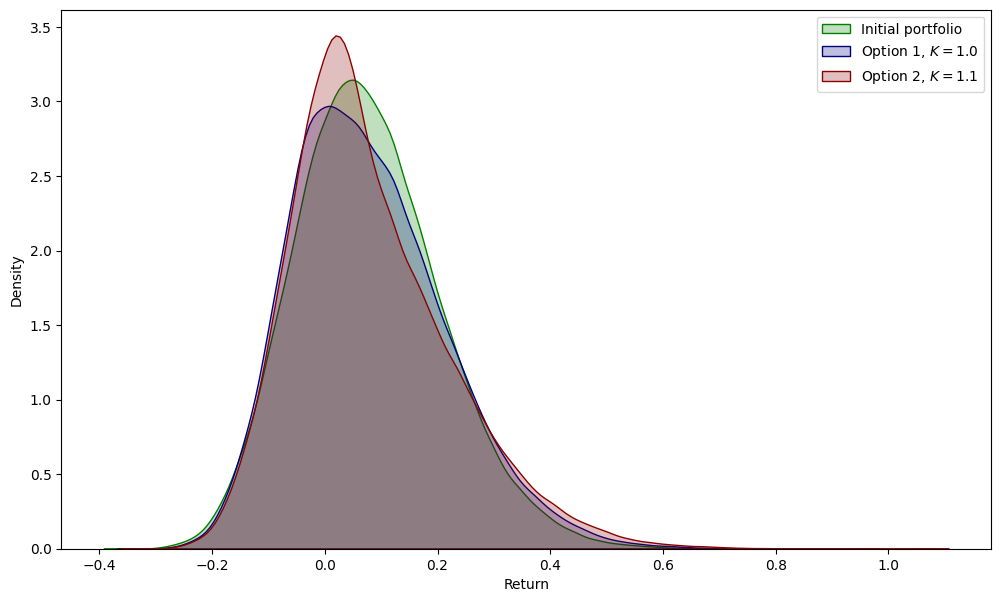

In [76]:
"""
Plot return profile
"""
fig, ax = plt.subplots(figsize=(12, 7))

sns.kdeplot(init_port_ret, color="green", label="Initial portfolio", fill=True, ax=ax)
sns.kdeplot(port_call1_ret, color="navy", label="Option 1, $K=1.0$", fill=True, ax=ax)
sns.kdeplot(port_call2_ret, color="darkred", label="Option 2, $K=1.1$", fill=True, ax=ax)

ax.set_xlabel("Return")
ax.legend();

In [77]:
"""
Tabulate relevant metrics
"""

df_port_values = pd.DataFrame({'Initial Portfolio': init_port_ret,
                               'Port. w. call option 1': port_call1_ret, 
                               'Port. w. call option 2': port_call2_ret})


"""
Calculate some relevant metrics
"""

calc_cvar = lambda x: rm.calculate_conditional_value_at_risk(np.asarray(x), p=0.05)
calc_var = lambda x: np.percentile(x, q=5, axis=0)

df_port_res = df_port_values.aggregate([mom.calculate_mean,
                                        np.median,
                                    mom.calculate_std,
                                    mom.calculate_skewness,
                                    mom.calculate_kurtosis,
                                    calc_cvar,
                                    calc_var])

df_port_res.index = pd.Index(['Mean', 'Median' , 'Standard deviation', 'Skewness', 'Kurtosis', 'CVaR(5%)', 'VaR(5%)'])
df_port_res

,Initial Portfolio,Port. w. call option 1,Port. w. call option 2
Mean,0.077646,0.078216,0.080393
Median,0.068378,0.062899,0.055449
Standard deviation,0.129957,0.137156,0.142316
Skewness,0.434698,0.616607,0.848086
Kurtosis,0.365914,0.491479,1.040119
CVaR(5%),-0.160000,-0.153788,-0.149688
VaR(5%),-0.119519,-0.117575,-0.113382


## Portfolio optimization with options

In [78]:
def calculate_target_portfolio_w_options(asset_prices, target, initial_prices, h_init=None):
    
    if h_init is None: 
        h_init = np.ones(asset_prices.shape[1]) / asset_prices.shape[1]
    
    obj = lambda h: -np.mean(asset_prices @ h)
    
    budget_constraint = {'type': 'eq', 'fun': lambda h: initial_prices @ h - 1.0}
    cvar_constraint = {'type': 'ineq', 'fun': lambda h: rm.calculate_conditional_value_at_risk(asset_prices @ h, p=0.05) - target}
    
    res = optimize.minimize(obj,
                   x0=h_init,
                   method='SLSQP',
                   constraints=[budget_constraint, cvar_constraint],
                   options={'disp': True,
                            'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1.5e-7},
                   bounds=[(0.0, 1.0 / p) for p in initial_prices])
    
    return res['x']

In [79]:
h_cvar_opt_w_calls = calculate_target_portfolio_w_options(asset_prices_w_call_payoff, 1 - 0.16, initial_prices, h_cvar_opt_)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1231305063608767
            Iterations: 52
            Function evaluations: 499
            Gradient evaluations: 51


In [95]:
df_full_opt = pd.DataFrame({'Holdings': h_cvar_opt_w_calls}, index=['Asset 1', 'Asset 2', 'Asset 3', 'Option 1', 'Option 2'])
df_full_opt.style.format('{:.3f}')

,Holdings
Asset 1,0.603
Asset 2,0.209
Asset 3,0.102
Option 1,0.000
Option 2,2.501


In [81]:
# check budget constraint
h_cvar_opt_w_calls @ initial_prices

1.0

In [83]:
"""
Tabulate relevant metrics
"""

opt_port_w_call_ret = asset_prices_w_call_payoff @ h_cvar_opt_w_calls - 1.0

df_port_values = pd.DataFrame({'Initial Portfolio': init_port_ret,
                               'Port. w. call option 1': port_call1_ret, 
                               'Port. w. call option 2': port_call2_ret,
                               'Optimal portfolio w. calls': opt_port_w_call_ret})


"""
Calculate some relevant metrics
"""

calc_cvar = lambda x: rm.calculate_conditional_value_at_risk(np.asarray(x), p=0.05)
calc_var = lambda x: np.percentile(x, q=5, axis=0)

df_port_res = df_port_values.aggregate([mom.calculate_mean,
                                        np.median,
                                        mom.calculate_std,
                                        mom.calculate_skewness,
                                        mom.calculate_kurtosis,
                                        calc_cvar,
                                        calc_var])

df_port_res.index = pd.Index(['Mean', 'Median' , 'Standard deviation', 'Skewness', 'Kurtosis', 'CVaR(5%)', 'VaR(5%)'])
df_port_res

,Initial Portfolio,Port. w. call option 1,Port. w. call option 2,Optimal portfolio w. calls
Mean,0.077646,0.078216,0.080393,0.123131
Median,0.068378,0.062899,0.055449,-0.019865
Standard deviation,0.129957,0.137156,0.142316,0.314670
Skewness,0.434698,0.616607,0.848086,1.925594
Kurtosis,0.365914,0.491479,1.040119,4.312135
CVaR(5%),-0.160000,-0.153788,-0.149688,-0.160000
VaR(5%),-0.119519,-0.117575,-0.113382,-0.137920


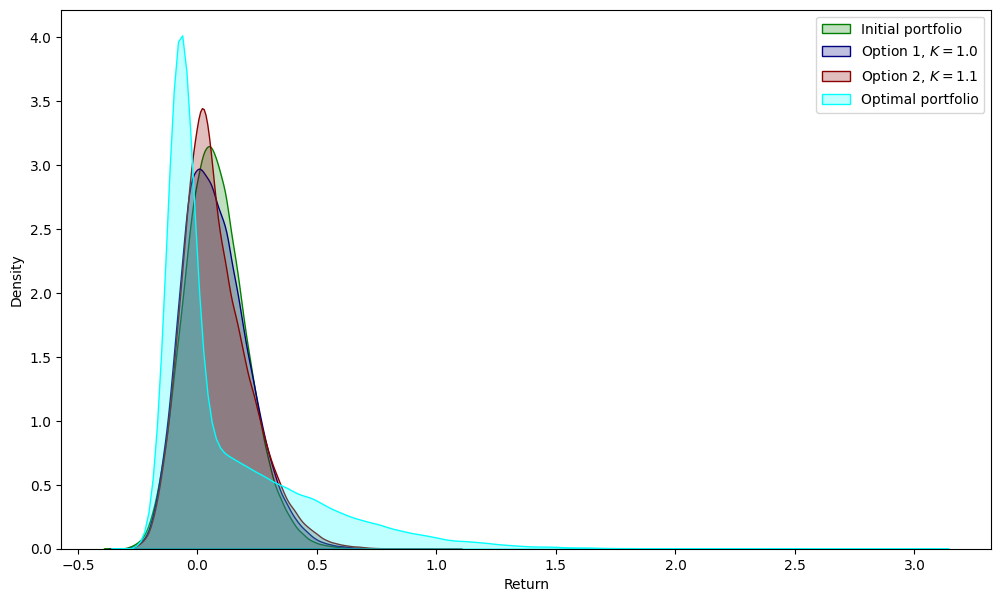

In [84]:
"""
Visualize return profile
"""

fig, ax = plt.subplots(figsize=(12, 7))

sns.kdeplot(init_port_ret, color="green", label="Initial portfolio", fill=True, ax=ax)
sns.kdeplot(port_call1_ret, color="navy", label="Option 1, $K=1.0$", fill=True, ax=ax)
sns.kdeplot(port_call2_ret, color="darkred", label="Option 2, $K=1.1$", fill=True, ax=ax)
sns.kdeplot(opt_port_w_call_ret, color="cyan", label="Optimal portfolio", fill=True, ax=ax)

ax.set_xlabel("Return")
ax.legend();